In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import YearEnd

In [2]:
def load_deepsearch_data(filepath, col_name):
    df=pd.read_excel(filepath)
    if len(df.columns)>2:
        del df[df.columns[-1]]
    df.columns=['date', col_name]
    
    df['date'] = df['date'].astype('str').str[:15]
    df['date'] = pd.to_datetime(df['date'])
    
    df=df.set_index('date')
    df=df.sort_index(ascending=True)
    return df

In [3]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:] 
    df = df.dropna() 
    df = df.astype(float)
    
    df['date'] =  pd.to_datetime(df.index) + YearEnd(0)
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [4]:
filenames = [
    'krw_cad_xr',
    'current_account_korea', 'current_account_can', 
    'gdp_korea', 'gdp_can', 
    'gdp_growth_korea', 'gdp_growth_can', 
    'cpi_korea', 'cpi_can',
    'int_rate_korea', 'int_rate_can', 
    'foreign_reserves_korea', 'foreign_reserves_can', # 외환보유액(한국,캐나다 ; 백만달러); monthly
]

In [5]:
dfs=[]
for fname in filenames:
    print(f'Loading {fname}...')
    filepath = f'data/{fname}.xlsx'
    df=load_deepsearch_data(filepath, fname)
    
    if fname in ['gdp_growth_korea', 'gdp_growth_can', \
                 'current_account_can']:#quarterly
        df=df.fillna(0)
        df[fname]=df.rolling(4).sum()
    elif fname in ['current_account_korea']:#monthly
        df=df.rolling(12).sum()
    dfs.append(df)
print('Data loading is completed!!')

Loading krw_cad_xr...
Loading current_account_korea...
Loading current_account_can...
Loading gdp_korea...
Loading gdp_can...
Loading gdp_growth_korea...
Loading gdp_growth_can...
Loading cpi_korea...
Loading cpi_can...
Loading int_rate_korea...
Loading int_rate_can...
Loading foreign_reserves_korea...
Loading foreign_reserves_can...
Data loading is completed!!


In [6]:
df_ppp_xr = load_world_bank_data('data/world_ppp_xr.xls', 'KOR','krw_usd_ppp_xr')
dfs.append(df_ppp_xr)
df_ppp_xr = load_world_bank_data('data/world_ppp_xr.xls', 'CAN','can_usd_ppp_xr')
dfs.append(df_ppp_xr)

In [7]:
dfs

[            krw_cad_xr
 date                  
 1964-12-14      236.81
 1964-12-15      236.81
 1964-12-16      236.81
 1964-12-17      236.81
 1964-12-18      236.81
 ...                ...
 2022-08-08     1003.98
 2022-08-09     1014.70
 2022-08-10     1012.73
 2022-08-11     1024.78
 2022-08-12     1020.25
 
 [16257 rows x 1 columns],
             current_account_korea
 date                             
 1980-01-31                    NaN
 1980-02-29                    NaN
 1980-03-31                    NaN
 1980-04-30                    NaN
 1980-05-31                    NaN
 ...                           ...
 2022-02-28                81798.7
 2022-03-31                81028.7
 2022-04-30                80768.2
 2022-05-31                74221.8
 2022-06-30                71001.1
 
 [510 rows x 1 columns],
             current_account_can
 date                           
 1950-03-31                  NaN
 1950-06-30                  NaN
 1950-09-30                  NaN
 1950-12-31 

In [8]:
df_merged = pd.concat(dfs, axis=1)
df_merged = df_merged.resample('M').last()
df_merged = df_merged.fillna(method = 'ffill')

In [9]:
df_merged['ann_ret'] = df_merged['krw_cad_xr'].pct_change(periods=12)*100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

In [10]:
df_merged['krw_can_ppp_xr'] = df_merged['krw_usd_ppp_xr'] / df_merged['can_usd_ppp_xr']
df_merged['real_xr_kor_can'] = df_merged['krw_can_ppp_xr'] / df_merged['krw_cad_xr']

In [11]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100

In [12]:
df_merged['ca_gdp_can'] = df_merged['current_account_can'] / df_merged['gdp_can'] * 100

In [13]:
df_merged['reserves_to_gdp_kor'] = \
    df_merged['foreign_reserves_korea'] / df_merged['gdp_korea'] 
df_merged['reserves_to_gdp_can'] = \
    df_merged['foreign_reserves_can'] / df_merged['gdp_can'] 

In [14]:
df_merged['reserves_growth_kor'] = df_merged['foreign_reserves_korea'].pct_change(periods=12)*100
df_merged['reserves_growth_can'] = df_merged['foreign_reserves_can'].pct_change(periods=12)*100

In [15]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods=12)*100
df_merged['infl_can'] = df_merged['cpi_can'].pct_change(periods=12)*100

In [16]:
df_merged['infl_diff_kor_can'] = df_merged['infl_korea']-df_merged['infl_can']

In [17]:
df_merged['int_rate_diff_kor_can'] = df_merged['int_rate_korea']-df_merged['int_rate_can']

In [18]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr_kor_can',
    'ca_gdp_korea', 'ca_gdp_can',
    'gdp_growth_korea', 'gdp_growth_can',
    'infl_diff_kor_can',
    'int_rate_diff_kor_can',
    'reserves_to_gdp_kor', 'reserves_to_gdp_can', 
    'reserves_growth_kor','reserves_growth_can',
    
]]

In [19]:
df_sample.head()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,gdp_growth_korea,gdp_growth_can,infl_diff_kor_can,int_rate_diff_kor_can,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_growth_kor,reserves_growth_can
date,,,,,,,,,,,,
1920-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_sample = df_sample.dropna()

In [21]:
df_sample.head()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,gdp_growth_korea,gdp_growth_can,infl_diff_kor_can,int_rate_diff_kor_can,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_growth_kor,reserves_growth_can
date,,,,,,,,,,,,
2006-01-31,-5.754104,0.767736,1.148198,1.869024,5.3,3.2,-0.536071,1.11,0.232086,0.028086,8.629988,-4.715236
2006-02-28,-5.383556,0.764927,0.720525,1.869024,5.3,3.2,-0.160040,0.85,0.231035,0.027852,6.820273,-8.090324
2006-03-31,-3.689371,0.771637,0.405913,2.152156,6.0,3.7,-0.171014,0.77,0.232526,0.030706,5.790788,-0.595862
2006-04-30,-1.124596,0.771949,0.224658,2.152156,6.0,3.7,-0.428234,0.63,0.238460,0.030435,8.001899,0.317389
2006-05-31,1.045666,0.758624,0.161548,2.152156,6.0,3.7,-0.515833,0.37,0.240384,0.030408,9.019408,1.855341


In [22]:
df_sample.tail()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,gdp_growth_korea,gdp_growth_can,infl_diff_kor_can,int_rate_diff_kor_can,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_growth_kor,reserves_growth_can
date,,,,,,,,,,,,
2021-04-30,9.904075,0.734072,5.478157,-0.926039,1.8,1.3,-0.898947,0.092,0.276153,0.051195,11.962909,-3.532901
2021-05-31,6.498453,0.716225,5.994930,-0.926039,1.8,1.3,-0.970922,0.083,0.278686,0.054214,12.066455,2.097926
2021-06-30,10.071879,0.726419,6.104289,-0.572349,5.8,11.5,-0.716976,0.405,0.277250,0.054122,10.554249,2.034900
2021-07-31,10.404016,0.717763,6.133675,-0.572349,5.8,11.5,-1.082709,0.386,0.280043,0.054818,10.120617,-0.222345
2021-08-31,10.436985,0.716527,6.185632,-0.572349,5.8,11.5,-1.537369,0.514,0.283250,0.064749,10.737055,18.514934


In [23]:
len(df_sample)

188

In [24]:
import seaborn as sns

<AxesSubplot:>

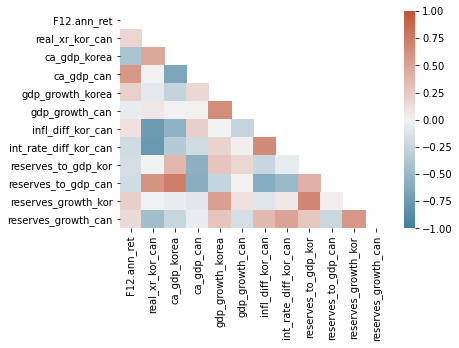

In [25]:
corr = df_sample.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) # two color
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=-1, vmax=1)

In [26]:
import statsmodels.api as sm

In [27]:
y = df_sample['F12.ann_ret']
x = df_sample.iloc[:, 1:]
x=sm.add_constant(x)

In [28]:
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     18.17
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           7.59e-24
Time:                        20:46:08   Log-Likelihood:                -586.39
No. Observations:                 188   AIC:                             1197.
Df Residuals:                     176   BIC:                             1236.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -38.5650     17.538     -2.199      0.029     -73.177      -3.953
real_xr_kor_can          39.2265     10.772      3.641      0.000      17.967      60.486
ca_gdp_korea             -0.9284      0.334     -2.779      0.006      -1.588      -0.269
ca_gdp_can                2.4799      0.597      4.156      0.000       1.302       3.658
gdp_growth_korea          0.2448      0.368      0.665      0.507      -0.481       0.971
gdp_growth_can           -0.1729      0.247     -0.701      0.484      -0.660       0.314
infl_diff_kor_can         1.8747      0.671      2.793      0.006       0.550       3.199
int_rate_diff_kor_can     0.2878      1.272      0.226      0.821      -2.223       2.799
reserves_to_gdp_kor      28.0846     54.068      0.519      0.604     -78.620     134.789
reserves_to_gdp_can     229.9806    100.618      2.286      0.023      31.407     428.554
reserves_growth_kor       0.1025      0.125      0.817      0.415      -0.145       0.350
reserves_growth_can       0.1518      0.092      1.645      0.102      -0.030       0.334
==============================================================================
Omnibus:                        1.750   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.484
Skew:                           0.030   Prob(JB):                        0.476
Kurtosis:                       3.431   Cond. No.                     3.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""